In [ ]:
! pip install -q -U tensorflow-text

In [ ]:
! pip install -q -U tf-models-official

In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as no
tf.get_logger().setLevel('ERROR')

In [ ]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recomended.')

Using TPU


In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocessing model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [ ]:
tfhub_handle_preprocess

'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1'

In [ ]:
tfhub_handle_encoder

'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

In [ ]:
bert_preprocess=hub.load(tfhub_handle_preprocess)
tok=bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))

In [ ]:
tok

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>

In [ ]:
text_preprocessed=bert_preprocess.bert_pack_inputs([tok,tok],tf.constant(20))

In [ ]:
text_preprocessed

{'input_mask': <tf.Tensor: shape=(1, 20), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 20), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(1, 20), dtype=int32, numpy=
 array([[  101,  7592, 23435, 12314,   999,   102,  7592, 23435, 12314,
           999,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0]], dtype=int32)>}

In [ ]:
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


In [ ]:
def make_bert_preprocess_model(sentence_features,seq_length=128):
  input_segments=[tf.keras.layers.Input(shape=(),dtype=tf.string,name=ft) for ft in sentence_features]
  bert_preprocess=hub.load(tfhub_handle_preprocess)
  tokenizer=hub.KerasLayer(bert_preprocess.tokenize,name="tokenizer")
  segments=[tokenizer(s) for s in input_segments]
  truncated_segments=segments
  packer=hub.KerasLayer(bert_preprocess.bert_pack_inputs,arguments=dict(seq_length=seq_length),name='packer')
  model_inputs=packer(truncated_segments)
  return tf.keras.Model(input_segments,model_inputs)

In [ ]:
import numpy as np


In [ ]:
test_preprocess_model=make_bert_preprocess_model(['my_input1','my_input2'])
test_text = [np.array(['some random test sentence']),np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

In [ ]:
print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


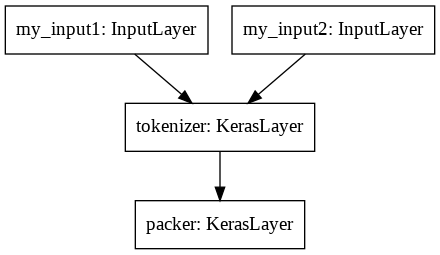

In [ ]:
tf.keras.utils.plot_model(test_preprocess_model)

In [ ]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
def load_dataset_from_tfds(in_memory_ds,info,split,batch_size,bert_preprocess_model):
  is_training=split.startswith('train')
  dataset=tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples=info.splits[split].num_examples
  if is_training:
    dataset=dataset.shuffle(num_examples)
    dataset=dataset.repeat()
  dataset=dataset.batch(batch_size)
  dataset=dataset.map(lambda ex:(bert_preprocess_model(ex),ex['label']))
  dataset=dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset,num_examples

In [ ]:
def build_classifier_model(num_classes):
  inputs=dict(input_word_ids=tf.keras.layers.Input(shape=(None,),dtype=tf.int32),
              input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
              input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),)
  encoder=hub.KerasLayer(tfhub_handle_encoder,trainable=True,name='encoder')
  net=encoder(inputs)['pooled_output']
  net=tf.keras.layers.Dropout(rate=0.1)(net)
  net=tf.keras.layers.Dense(num_classes,activation=None,name='classifier')(net)
  return tf.keras.Model(inputs,net,name='prediction')

In [ ]:
test_classifier_model=build_classifier_model(2)
bert_raw_result=test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.77898085 0.4651242 ]], shape=(1, 2), dtype=float32)


In [ ]:
tf.keras.utils.plot_model

<function tensorflow.python.keras.utils.vis_utils.plot_model>

In [ ]:
tfds_name='glue/cola'
tfds_info=tfds.builder(tfds_name).info
sentence_features=list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')
available_splits=list(tfds_info.splits.keys())
train_split='train'
validation_split='validation'
test_split='test'
if tfds_name=='glue/mnli':
  validation_split='validation_matched'
  test_split='test_matched'
num_classes=tfds_info.features['label'].num_classes
num_examples=tfds_info.splits.total_num_examples

In [ ]:
available_splits

['test', 'train', 'validation']

In [ ]:
tfds_info

In [ ]:
num_classes

2

In [ ]:
num_examples

10657

In [ ]:
print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['test', 'train', 'validation']


In [ ]:
with tf.device('/job:localhost'):
  in_memory_ds=tfds.load(tfds_name,batch_size=-1,shuffle_files=True)
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])
labels_names = tfds_info.features['label'].names
print(labels_names)
print()

Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteXQXF95/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteXQXF95/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/cola/1.0.0.incompleteXQXF95/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/1.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']



In [ ]:
sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)



In [ ]:
labels_names

['unacceptable', 'acceptable']

In [ ]:
def get_configuration(glue_task):
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  if glue_task is 'glue/cola':
    metrics=tfa.metrics.MatthewsCorrelationCoefficient()
  else:
    metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy',dtype=tf.float32)
  return metrics,loss

In [ ]:
samples

In [ ]:
epochs=3
batch_size=32
init_lr=2e-5
print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model=make_bert_preprocess_model(sentence_features)
with strategy.scope():
  metrics,loss=get_configuration(tfds_name)
  train_dataset,train_data_size=load_dataset_from_tfds(in_memory_ds,tfds_info,train_split,batch_size,bert_preprocess_model)
  steps_per_epoch=train_data_size//batch_size
  num_train_steps=steps_per_epoch*epochs
  num_warmup_steps=num_train_steps//10
  validation_dataset,validation_data_size=load_dataset_from_tfds(in_memory_ds,tfds_info,validation_split,batch_size,bert_preprocess_model)
  validation_steps=validation_data_size//batch_size
  classifier_model=build_classifier_model(num_classes)
  optimizer=optimization.create_optimizer(init_lr=init_lr,num_train_steps=num_train_steps,num_warmup_steps=num_warmup_steps,optimizer_type='adamw')
  classifier_model.compile(optimizer=optimizer,loss=loss,metrics=[metrics])
  classifier_model.fit(x=train_dataset,validation_data=validation_dataset,steps_per_epoch=steps_per_epoch,epochs=epochs,validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 1/3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


267/267 [==============================] - 63s 236ms/step - loss: 0.5146 - accuracy: 0.7518 - val_loss: 0.4470 - val_accuracy: 0.8125
Epoch 2/3
267/267 [==============================] - 25s 94ms/step - loss: 0.3034 - accuracy: 0.8749 - val_loss: 0.4295 - val_accuracy: 0.8213
Epoch 3/3
267/267 [==============================] - 25s 94ms/step - loss: 0.1788 - accuracy: 0.9338 - val_loss: 0.5096 - val_accuracy: 0.8262


In [ ]:
bert_preprocess_model.inputs

[<tf.Tensor 'sentence:0' shape=(None,) dtype=string>]

In [ ]:
main_save_path='./my_models'
bert_type=tfhub_handle_encoder.split('/')[-2]
saved_model_name=f'{tfds_name.replace("/", "_")}_{bert_type}'
saved_model_path=os.path.join(main_save_path,saved_model_name)
preprocess_inputs=bert_preprocess_model.inputs
bert_encoder_inputs=bert_preprocess_model(preprocess_inputs)
bert_outputs=classifier_model(bert_encoder_inputs)
model_for_export=tf.keras.Model(preprocess_inputs,bert_outputs)
print(f'Saving {saved_model_path}')
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False, options=save_options)

Saving ./my_models/glue_cola_bert_en_uncased_L-12_H-768_A-12


In [ ]:
load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
reloaded_model = tf.saved_model.load(saved_model_path, options=load_options)

In [ ]:
def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs


def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs


def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  if dataset_name == 'glue/cola':
    print(f'sentence: {test[0].numpy()}')
    if bert_result_class == 1:
      print(f'This sentence is acceptable')
    else:
      print(f'This sentence is unacceptable')

  elif dataset_name == 'glue/sst2':
    print(f'sentence: {test[0]}')
    if bert_result_class == 1:
      print(f'This sentence has POSITIVE sentiment')
    else:
      print(f'This sentence has NEGATIVE sentiment')

  elif dataset_name == 'glue/mrpc':
    print(f'sentence1: {test[0]}')
    print(f'sentence2: {test[1]}')
    if bert_result_class == 1:
      print(f'Are a paraphrase')
    else:
      print(f'Are NOT a paraphrase')

  elif dataset_name == 'glue/qqp':
    print(f'question1: {test[0]}')
    print(f'question2: {test[1]}')
    if bert_result_class == 1:
      print(f'Questions are similar')
    else:
      print(f'Questions are NOT similar')

  elif dataset_name == 'glue/mnli':
    print(f'premise   : {test[0]}')
    print(f'hypothesis: {test[1]}')
    if bert_result_class == 1:
      print(f'This premise is NEUTRAL to the hypothesis')
    elif bert_result_class == 2:
      print(f'This premise CONTRADICTS the hypothesis')
    else:
      print(f'This premise ENTAILS the hypothesis')

  elif dataset_name == 'glue/qnli':
    print(f'question: {test[0]}')
    print(f'sentence: {test[1]}')
    if bert_result_class == 1:
      print(f'The question is NOT answerable by the sentence')
    else:
      print(f'The question is answerable by the sentence')

  elif dataset_name == 'glue/rte':
    print(f'sentence1: {test[0]}')
    print(f'sentence2: {test[1]}')
    if bert_result_class == 1:
      print(f'Sentence1 DOES NOT entails sentence2')
    else:
      print(f'Sentence1 entails sentence2')

  elif dataset_name == 'glue/wnli':
    print(f'sentence1: {test[0]}')
    print(f'sentence2: {test[1]}')
    if bert_result_class == 1:
      print(f'Sentence1 DOES NOT entails sentence2')
    else:
      print(f'Sentence1 entails sentence2')

  print(f'Bert raw results:{bert_result[0]}')
  print()

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
for test_row in test_dataset.shuffle(1000).map(prepare).take(5):
  if len(sentence_features) == 1:
    result = reloaded_model(test_row[0])
  else:
    result = reloaded_model(list(test_row))
  print_bert_results(test_row, result, tfds_name)

sentence: [b'The evidence that was assembled by the prosecution convinced the jury.']
This sentence is acceptable
Bert raw results:[-0.69832957  1.550789  ]

sentence: [b"Every essay she's written and that I've read is on that pile."]
This sentence is acceptable
Bert raw results:[0.04512892 0.93129903]

sentence: [b'I am counting on you for Mary to get there on time.']
This sentence is acceptable
Bert raw results:[-1.2020872  2.2474208]

sentence: [b"I borrowed Fred's diagram of a snake's fang because Steve's of a spider's eye had been stolen."]
This sentence is acceptable
Bert raw results:[-1.266284   2.2153065]

sentence: [b'Lee never left.']
This sentence is acceptable
Bert raw results:[-2.1231642  3.114113 ]



In [ ]:
serving_model = reloaded_model.signatures['serving_default']
for test_row in test_dataset.shuffle(1000).map(prepare_serving).take(5):
  result = serving_model(**test_row)
  print_bert_results(list(test_row.values()), result['prediction'], tfds_name)

sentence: b"We don't know with whom she's been dancing."
This sentence is acceptable
Bert raw results:[-0.5936873  1.4774063]

sentence: b'John will have been enthusiastically eating cake.'
This sentence is acceptable
Bert raw results:[-2.9280746  3.3350463]

sentence: b'John is impressed as pompous.'
This sentence is unacceptable
Bert raw results:[ 1.6051627 -1.4427012]

sentence: b'That silly fool broke the teapot.'
This sentence is acceptable
Bert raw results:[-2.6629012  3.2599578]

sentence: b'Pat is fond of Chris.'
This sentence is acceptable
Bert raw results:[-2.2592096  3.6607368]

